In [1]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
from tqdm.auto import trange 

import ssm
from ssm.messages import hmm_sample


# Sample synthetic data

In [2]:
num_factors = 3
num_states = 2
emission_dim = 10

hypers = dict(num_factors=num_factors,
              num_states=num_states,
              emission_dim=emission_dim)

num_timesteps = 1000

initial_dist = np.ones((num_factors, num_states)) / num_states
transition_matrix = 0.9 * np.eye(num_states) + 0.1 * np.roll(np.eye(num_states), 1, axis=1)
transition_matrices = np.tile(transition_matrix, (num_factors, 1, 1))

means = 3 * npr.randn(num_factors, num_states, emission_dim)
# means = np.zeros((num_factors, num_states, emission_dim))
# means[1] = npr.gamma(10.0, 1.0, size=(num_states, emission_dim))
# variances = 0.1 * np.ones((num_factors, num_states, emission_dim))
variances=0.5*np.ones(emission_dim)

params = dict(initial_dist=initial_dist,
              transition_matrices=transition_matrices,
              means=means,
              variances=variances)

true_states = np.zeros((num_timesteps, num_factors), dtype=int)
emissions = np.zeros((num_timesteps, emission_dim))
expec_emissions = np.zeros((num_timesteps, emission_dim))

npr.seed(0)
for t in range(num_timesteps):
    for h in range(num_factors):
        if t > 0:
            true_states[t, h] = \
              npr.choice(num_states, p=transition_matrices[h, true_states[t-1, h]])
        
    # mean = np.zeros(emission_dim)
    # for h in range(num_factors):      
    #     mean += means[h, states[t,h], :]
    expec_emissions[t] = np.sum(means[np.arange(num_factors), true_states[t]], axis=0)
    emissions[t] = expec_emissions[t] + np.sqrt(variances) * npr.randn(emission_dim)

(300.0, 400.0)

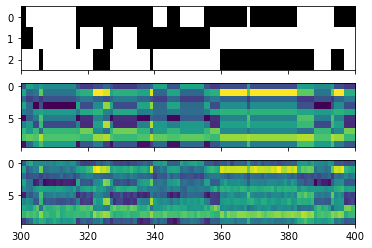

In [3]:
fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].imshow(true_states.T, aspect="auto", interpolation="none", cmap="Greys")
axs[1].imshow(expec_emissions.T, aspect="auto", interpolation="none")
axs[2].imshow(emissions.T, aspect="auto", interpolation="none")

# axs[3].imshow(mean, aspect="auto", interpolation="none")

plt.xlim(300, 400)

# Inference via Gibbs sampling

Let $z_{t,h} \in \{1,\ldots,K\}$ be the state of factor $h$ at time $t$. The emissions are,

\begin{align}
x_{t,n} \sim N(\sum_h \mu_{h,z_{t,h},n}, \sum_h \sigma_{h,z_{t,h},n}^2)
\end{align}

However, we restrict to a simpler model where *all states from all factors* share the same variance $\sigma_{h,z_{t,h},n}^2=\sigma_{n}^2$

\begin{align}
x_{t,n} \sim N(\sum_h \mu_{h,z_{t,h},n}, \sigma_{n}^2)
\end{align}

To infer the parameters for factor $h$, we assume that observations $x_{t,n}$ are sampled from the likelihood of the data given the other factors, equal to a normal distribution with mean $\sum_{h'\neq h} \mu_{h',z_{t,h'},n}$ equal to the sum of the other factors $h'\neq h$, using the states $z_{t,h}$ inferred from the previous Gibbs sampling iteration, and calculate the residuals. Then, the new parameter estimate for the mean $\mu_{h,z_{t,h},n}$ of factor $h$ is the mean of the residuals. In other words, $\mu_{h,z_{t,h},n}$ is sampled from the posterior
\begin{align}
\mu_{h,z_{t,h},n} \sim \prod_t N(x_{t,n}|\sum_{h'\neq h} \mu_{h',z_{t,h'},n}, \sigma_{n}^2)
\end{align}


In [4]:
from scipy.stats import norm




def _m_step(gammat_gibbs,states_outer_gibbs, trans_gibbs,emissions, params, hypers):
    """
    Find parameters with exact M-step using state probabilities estimated from Gibbs sampling 
    """
    num_factors = hypers["num_factors"]
    num_states = hypers["num_states"]
    num_timesteps = gammat_gibbs.shape[0]
    params_sample=params.copy()

    # initial state probabilities
    params_sample["initial_dist"]=gammat_gibbs[0,:,:].T
    transition_matrix=np.mean(trans_gibbs,axis=0)/np.mean(gammat_gibbs[1:],axis=0)
    # aa=np.mean(gammat_gibbs[1:],axis=0) #states x factors
    # transition_matrix=np.mean(trans_gibbs,axis=0)/aa
    # if np.any(aa.flatten()==0):
    #     print('some states have zero probabilities')
    #     zeroind=np.where(aa==0)
    #     for irep in range(len(zeroind)):
    #           transition_matrix[zeroind[irep][0],:,zeroind[irep][1]]=1/num_states
    #     # print(aa.shape)
    #     # print(zeroind)
    #     # if there's an infinite entry, keep the former value
    #     # transition_matrix=params_sample['transition_matrices']
    #     # aa=np.linalg.pinv(np.mean(gammat_gibbs[1:],axis=0)).T
    #     # print(aa)
    transition_matrix=np.transpose(transition_matrix,(2,0,1))
    print(transition_matrix)

    params_sample['transition_matrices']=transition_matrix
    # means
    # reshape arrays for convenience
    gammat_re=np.reshape(gammat_gibbs,(num_timesteps,num_factors*num_states))
    states_outer_gibbs_re=np.reshape(np.transpose(states_outer_gibbs,(0,1,3,2,4)),(num_timesteps,num_states*num_factors,num_factors*num_states))
    means_first=np.matmul(emissions.T,gammat_re) # emission_dim x num_states*num_factors
    means_second=np.sum(states_outer_gibbs_re,axis=0) # num_states*num_factors  x num_states*num_factors
    # # check that means_second is symmetric
    # a=means_second-means_second.T
    # print("means_second is symmetric up to "+str(a.max()))

    means_second_inv=np.linalg.pinv(means_second)
    # # check that means_second is symmetric
    # a=means_second_inv-means_second_inv.T
    # print("means_second_inv is symmetric up to "+str(a.max()))
    means=np.matmul(means_first,means_second_inv) # emission_dim x num_states*num_factors
    
    # # consistency check: check that 'means' satisfy m-step condition (because moore-penrose pinv is approximate)
    # firstterm=np.matmul(means,np.reshape(np.transpose(states_outer_gibbs_re,(1,0,2)),(num_states*num_factors,num_states*num_factors*num_timesteps))) # emission_dim x num_timesteps x num_factors*num_states
    # firstterm=np.sum(np.reshape(firstterm,(emission_dim,num_timesteps,num_factors*num_states)),axis=1)
    # secondterm=np.zeros((emission_dim,num_timesteps,num_factors*num_states))
    # for t in range(num_timesteps):
    #       secondterm[:,t,:]=np.outer(emissions[t,:],gammat_re[t,:])
    # secondterm=np.sum(secondterm,axis=1)
    # a=firstterm-secondterm
    # print('m-step condition for means is zero up to '+str(a.max()))


    # variances
    Cnew_first=(1/num_timesteps)*np.matmul(emissions.T,emissions)
    Cnew_sec1=(1/num_timesteps)*np.matmul(emissions.T,gammat_re) # D x num_states*num_factors
    Cnew_sec=np.matmul(Cnew_sec1,means.T)
    # # check that Cnew_sec is symmetric
    # a=Cnew_sec-Cnew_sec.T
    # print("Cnew_sec is symmetric up to "+str(a.max()))
    Cnew=Cnew_first-Cnew_sec # D x D

    means=np.transpose(np.reshape(means,(emission_dim,num_states,num_factors)),(2,1,0))
    # print('means.shape',means.shape)
    params_sample["means"]=means
    params_sample["variances"]=np.diag(Cnew)
    return params_sample


def _gibbs_sample_states(h, states, emissions, params, hypers):
    """Sample sequence of states for factor h given the other factors.
    """
    num_factors = hypers["num_factors"]
    num_states = hypers["num_states"]
    num_timesteps = states.shape[0]
    means = params["means"]
    variances = params["variances"]

    lls = np.zeros((num_timesteps, num_states))
    tmp_states = states.copy()
    for k in range(num_states):
        tmp_states[:, h] = k
        expec_emissions = np.zeros_like(emissions)
        var_emissions = np.zeros_like(emissions)
        for j in range(num_factors):
            expec_emissions += means[j, tmp_states[:, j], :]
        var_emissions = variances

      
        lls[:, k] = norm(expec_emissions, np.sqrt(var_emissions)).logpdf(emissions).sum(axis=1)

    return hmm_sample(params["initial_dist"][h],
                             params["transition_matrices"][h][None, :, :],
                             lls)  

def gibbs(initial_states, emissions, params, hypers, options):
    num_factors = hypers["num_factors"]
    params=params.copy()
    samples = []
    params_samples = []
    for iopt in trange(options["num_runs"]):
        print("iopt",iopt)
        gammat_runs=[]
        states_outer_runs=[]
        trans_runs=[]
        # collect posteriors for num_runs independent runs of the gibbs sampling
        # then get state probabilities by averaging across runs
        for igibbs in range(options["num_gibbs"]):
            states=initial_states.copy()
            # params['means']=npr.randn(num_factors, num_states, emission_dim)
            # run num_iters steps of gibbs for states convergence
            for itr in range(options["num_iters"]):
                for h in range(num_factors):
                    states[:, h] = _gibbs_sample_states(h, states, emissions, params, hypers)
            # turn state sample at the end of the gibbs run into one-hot posterior probability distribution
            # gammat=post prob [S_t^(m)]_k for time t, factor m, state k
            # state_outer=post prob [S_t^(m1)]_k1 [S_t^(m2)]_k2 for time t, factors m1,m2, states k1,k2
            # states=true_states.copy()
            gammat=np.zeros((num_timesteps,num_states,num_factors))
            for h in range(num_factors):
                    tmp_states=states[:,h]
                    gammat_h = np.zeros((tmp_states.size, num_states))
                    gammat_h[np.arange(tmp_states.size), tmp_states] = 1
                    gammat[:,:,h]=gammat_h
            state_outer=np.zeros((num_timesteps,num_states,num_states,num_factors,num_factors))
            for h1 in range(num_factors):
                    for h2 in range(num_factors):
                            for t in range(num_timesteps):
                                state_outer[t,:,:,h1,h2]=np.outer(gammat[t,:,h1],gammat[t,:,h2])

            trans=np.zeros((num_timesteps-1,num_states,num_states,num_factors))
            for h in range(num_factors):
                    for t in range(num_timesteps-1):
                                trans[t,:,:,h]=np.outer(gammat[t+1,:,h],gammat[t,:,h])
            gammat_runs.append(gammat)
            states_outer_runs.append(state_outer)
            trans_runs.append(trans)

        # average over independent runs of gibbs to obtain posterior prob for exact m-step below 
        gammat_gibbs=np.mean(gammat_runs,axis=0)
        states_outer_gibbs=np.mean(states_outer_runs,axis=0)
        trans_gibbs=np.mean(trans_runs,axis=0)


        # params = _gibbs_sample_params(states, emissions, params, hypers)
        # get parameters using m_step
        params = _m_step(gammat_gibbs,states_outer_gibbs, trans_gibbs,emissions, params, hypers)

        samples.append(states)
        params_samples.append(params)
    
    return samples, params_samples


npr.seed(456)
# initialize parameters randomly
transition_probs=[]
initial_states = np.zeros((num_timesteps, num_factors), dtype=int)
initial_dist = np.ones((num_factors, num_states)) / num_states
init_transition_matrix = 0.8 * np.eye(num_states) + 0.2 * np.roll(np.eye(num_states), 1, axis=1)
init_transition_matrices = np.tile(transition_matrix, (num_factors, 1, 1))
init_emission_means = npr.randn(num_factors, num_states, emission_dim)
# amin,amax=[emissions.min(),emissions.max()]
# init_emission_means =amin+(amax-amin)*npr.rand(num_factors, num_states, emission_dim)
init_variances=np.ones(emission_dim)
initial_params=dict(transition_matrices=init_transition_matrices,
              means=init_emission_means,
              variances=init_variances,
              initial_dist=initial_dist)
options=dict(num_runs=10, # iterations of the Gibbs-Maximization loop
             num_gibbs=10, # samples of Gibbs collected to estimate posterior probs
             num_iters=10) # iterations of gibbs sampling for convergence of a state sequence
samples, params_samples = gibbs(initial_states, emissions, initial_params, hypers, options)

# samples, params_samples = gibbs(true_states, emissions, initial_params, hypers, options)


params_fit=params_samples[-1]

samples_fit=samples[-1]


  0%|          | 0/10 [00:00<?, ?it/s]

iopt 0
[[[0.81986143 0.06331169]
  [0.1812933  0.93628247]]

 [[0.9051016  0.08184191]
  [0.0970601  0.91629381]]

 [[0.93617021 0.18951132]
  [0.06516794 0.80651569]]]
iopt 1
[[[0.88918586 0.10515021]
  [0.11081414 0.89484979]]

 [[0.90212932 0.10285362]
  [0.09787068 0.89714638]]

 [[0.90525114 0.10519645]
  [0.09665145 0.89269117]]]
iopt 2
[[[0.90449438 0.10967742]
  [0.09550562 0.89032258]]

 [[0.90234375 0.1026694 ]
  [0.09765625 0.8973306 ]]

 [[0.89840637 0.10261569]
  [0.10358566 0.89537223]]]
iopt 3
[[[0.90449438 0.10967742]
  [0.09550562 0.89032258]]

 [[0.90234375 0.1026694 ]
  [0.09765625 0.8973306 ]]

 [[0.89840637 0.10261569]
  [0.10358566 0.89537223]]]
iopt 4
[[[0.90449438 0.10967742]
  [0.09550562 0.89032258]]

 [[0.90234375 0.1026694 ]
  [0.09765625 0.8973306 ]]

 [[0.89840637 0.10261569]
  [0.10358566 0.89537223]]]
iopt 5
[[[0.90449438 0.10967742]
  [0.09550562 0.89032258]]

 [[0.90234375 0.1026694 ]
  [0.09765625 0.8973306 ]]

 [[0.89840637 0.10261569]
  [0.10358566 

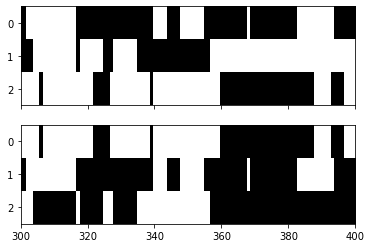

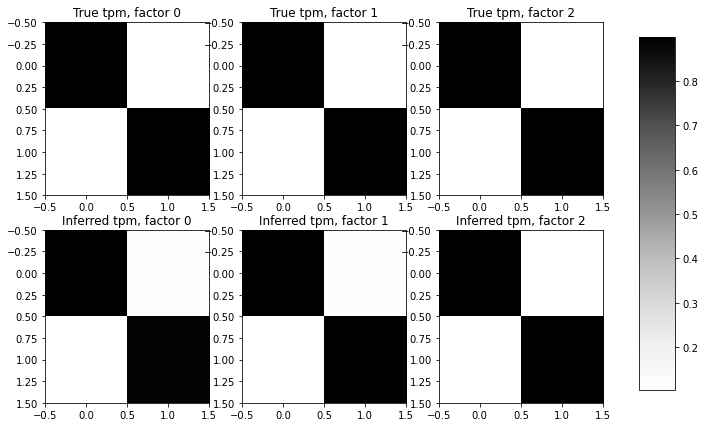

True means factor 0  [[ 2.01904755  0.28986483 -3.26861127 -0.44708422  0.53044031  0.6979856
  -1.30384781  1.08139327  2.32305097  2.2923657 ]
 [-3.78770078  4.95827226 -0.53108936  3.99565167  1.57985761 -4.36719689
  -3.17503208  3.14045586  1.59061036 -3.05223325]]
Inferred means factor 0  [[-0.98228227 -2.1039586  -0.42611549 -2.60285887 -0.11781734 -3.47491572
  -3.56802047  3.17240965  0.50632762 -1.86433733]
 [ 0.35166015  4.66766764 -2.14049541  2.04977899  0.62806463  2.34689854
   4.73282092 -2.54902472  3.67056712  0.76319481]]
True means factor 1  [[-2.31201161 -0.02411247 -2.52364867 -4.00847388  0.53591214  0.564105
  -1.80430507  0.5675878   1.44853834  1.79714491]
 [-0.476496   -0.91232088 -3.78487551  2.39813355 -3.00115572 -1.66480329
   4.09823225 -1.6909846   2.13703991 -2.28072218]]
Inferred means factor 1  [[ 2.57828343 -1.0388858  -2.679202   -2.45807124 -0.268947    1.95880565
   1.48571588 -0.73223628  2.43074691  2.07348881]
 [-3.20890555  3.60259484  0.1125

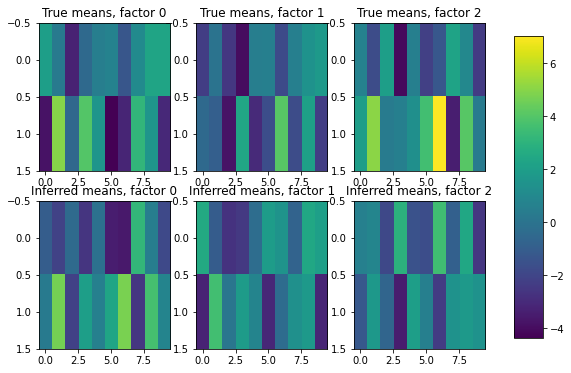

True variances [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Inferred variances [0.51237973 0.51995095 0.48999538 0.49461425 0.51015762 0.46691407
 0.5145629  0.50462878 0.47957744 0.54305841]


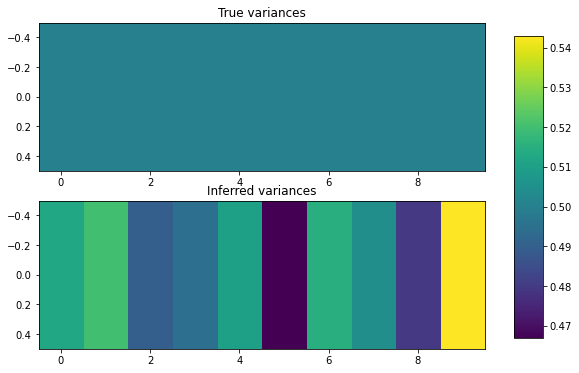

In [6]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].imshow(true_states.T, aspect="auto", interpolation="none", cmap="Greys")
axs[1].imshow(samples[-1].T, aspect="auto", interpolation="none", cmap="Greys")
plt.xlim(300, 400)

fig = plt.figure(figsize=(10, 7))
rows = 2
columns = num_factors
values=[params['transition_matrices'].flatten(),params_fit['transition_matrices'].flatten()]
vmin=np.min(values); vmax=np.max(values)
for h in range(num_factors):
          fig.add_subplot(rows, columns, h+1)
          im=plt.imshow(params['transition_matrices'][h], aspect="auto", cmap="Greys")
          plt.title("True tpm, factor "+str(h))
          fig.add_subplot(rows, columns, h+num_factors+1)
          im=plt.imshow(params_fit['transition_matrices'][h], aspect="auto", cmap="Greys")
          plt.title("Inferred tpm, factor "+str(h))
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout
plt.show()

vmin=np.min([params['means'].flatten(),params_fit['means'].flatten()]); vmax=np.max([params['means'].flatten(),params_fit['means'].flatten()])
fig=plt.figure(figsize=(8,6))
for h in range(num_factors):
          ax = plt.subplot(rows, columns, h+1)
          im=ax.imshow(params['means'][h], aspect="auto", vmin=vmin, vmax=vmax)
          print('True means factor '+str(h)+' ',str(params['means'][h]))
          ax.set_title("True means, factor "+str(h))
          ax = plt.subplot(rows, columns, h+1+num_factors)
          im=ax.imshow(params_fit['means'][h], aspect="auto", vmin=vmin, vmax=vmax)
          print('Inferred means factor '+str(h)+' ',str(params_fit['means'][h]))
          ax.set_title("Inferred means, factor "+str(h))
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout
plt.show()

values=[params['variances'].flatten(),params_fit['variances'].flatten()]
vmin=np.min(values); vmax=np.max(values)
fig=plt.figure(figsize=(8,6))
ax = plt.subplot(2, 1, 1)
im=ax.imshow(np.expand_dims(params['variances'], axis=0), aspect="auto", vmin=vmin, vmax=vmax)
print('True variances '+str(params['variances']))
ax.set_title("True variances")
ax = plt.subplot(2,1,2)
im=ax.imshow(np.expand_dims(params_fit['variances'], axis=0), aspect="auto", vmin=vmin, vmax=vmax)
print('Inferred variances '+str(params_fit['variances']))
ax.set_title("Inferred variances")
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout
plt.show()

